In [ ]:
# --- 1. Análise e Visualização ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import missingno as msno

# --- 2. Pré-processamento e Pipeline ---
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 3. Divisão de Dados ---
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# --- 4. Modelos ---
# Baseline: Regressão Logística
from sklearn.linear_model import LogisticRegression

# Modelos Robustos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# --- 5. Métricas de Avaliação  ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 6. Deploy ---
import joblib
import warnings
warnings.filterwarnings('ignore') # Para limpar o output da apresentação

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Classe                              29 non-null     object
 1   Embarcação                          29 non-null     object
 2   Sigla                               29 non-null     object
 3   Data                                29 non-null     object
 4   Local de realização                 29 non-null     object
 5   Regiões do casco limpas             11 non-null     object
 6   Condição geral da embarcação        29 non-null     object
 7   Tipo de incrustação da embarcação   27 non-null     object
 8   Condição do fundo chato             29 non-null     object
 9   Tipo de incrustação do fundo chato  24 non-null     object
 10  Condição do costado                 29 non-null     object
 11  Tipo de incrustação do costado      27 non-null     object
 

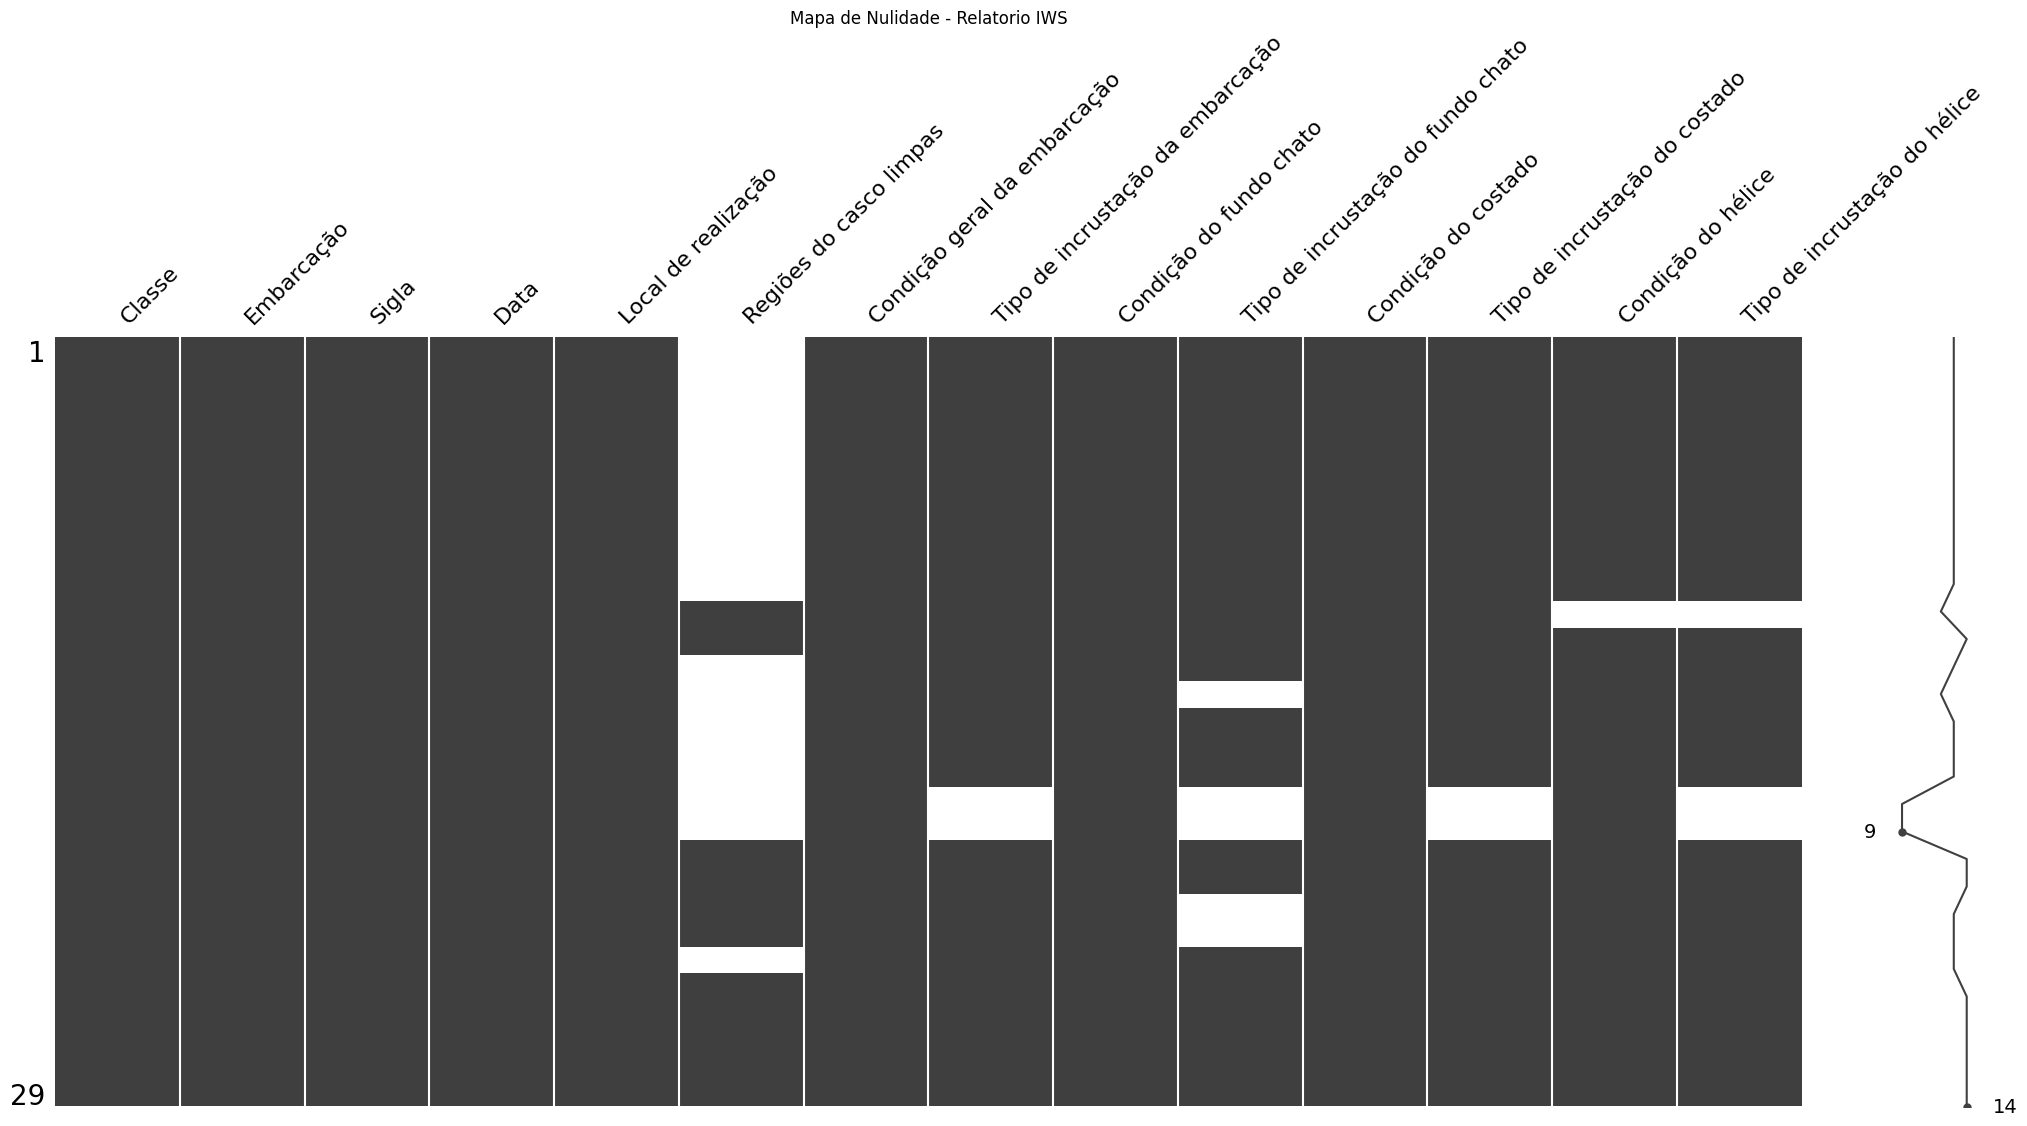

In [ ]:
#============= Detalhamento Relatorios ===========
# A tabela IWS é o Ground Truth, pois possui dados da limpeza.
# É aqui que informa condições de limpeza, nivel de bioincrustração e qual tipo.
#==================================================

df_relatorios = pd.read_csv("/content/Relatorios IWS.xlsx - Planilha1.csv")

print(df_relatorios.info())
print((df_relatorios.isnull().sum() / len(df_relatorios) * 100).sort_values(ascending=False))

msno.matrix(df_relatorios)
plt.title("Mapa de Nulidade - Relatorio IWS")
plt.show()

O que os dados mostram: Temos um dataset pequeno (29 registros), mas de altíssimo valor (Ground Truth). Isso significa que cada linha é preciosa e não podemos descartar dados levianamente.

A "Má Notícia": A coluna Regiões do casco limpas tem 62% de nulos.

Em relatórios de inspeção, um campo nulo muitas vezes não é um erro, mas sim uma informação: "Nada a reportar" ou "Nenhuma limpeza realizada neste ponto".

Tipagem: Todas as colunas estão como object (texto), o que exigirá conversão forçada para numérico nas colunas de condição.

Condição Geral da Embarcação
Valores únidos encontrados (amostra):
['100%' '10%' '30%' '20%' '90%' '80%' '  3 ' '50%' '70%' '5%' '2' '60%'
 '0%' '70-80%' 'Não avaliado' '45%']


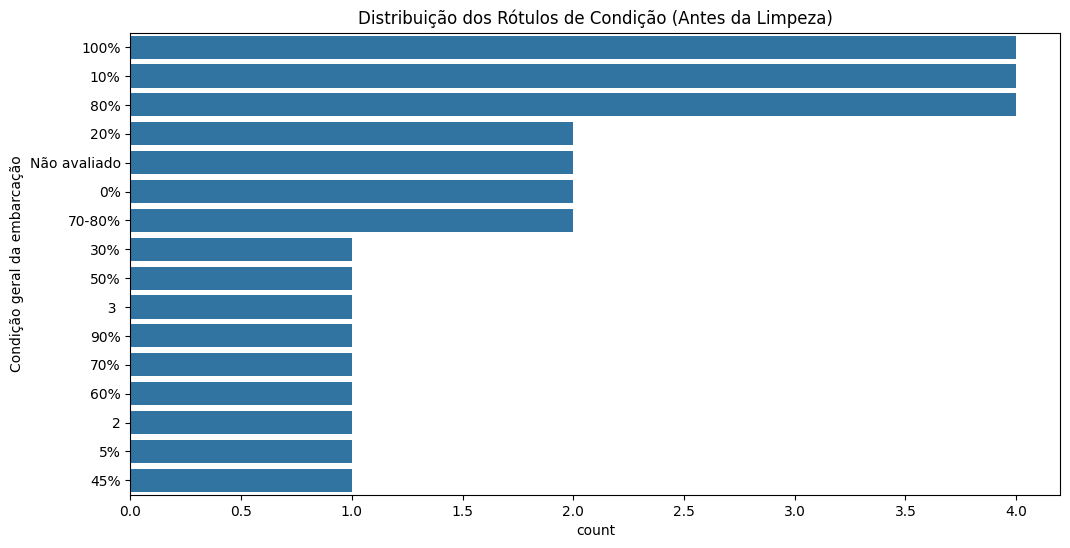

In [ ]:
#==================================
# VARIAVEL ALVO (y)
#==================================

print("Condição Geral da Embarcação")
print("Valores únidos encontrados (amostra):")
print(df_relatorios['Condição geral da embarcação'].unique())

plt.figure(figsize=(12,6))
sns.countplot(y='Condição geral da embarcação', data=df_relatorios, order=df_relatorios['Condição geral da embarcação'].value_counts().index)
plt.title("Distribuição dos Rótulos de Condição (Antes da Limpeza)")
plt.show()

O que os dados mostram: A coluna alvo (y) apresenta uma inconsistência crítica de formatação. Identificamos quatro padrões distintos misturados na mesma coluna:

Percentuais Limpos: '100%', '10%' (O ideal).

Intervalos: '70-80%' (Ambiguidade matemática).

Escalas Numéricas Soltas: ' 3 ', '2' (Provavelmente uma escala de nível 0-4 conforme documentaçao).

Texto de Falha: 'Não avaliado' (Dado inútil para treino supervisionado).

### Regra Proposta:

'Não avaliado' -> Remover linha.

'70-80%' -> Converter para a média (75%).

Números soltos (3) -> Normalizar na escala fornecida.
Final: Converter a % contínua em classes discretas: 0-10% (Limpo/Nível 0), 11-40% (Médio/Nível 1), >40% (Crítico/Nível 2).

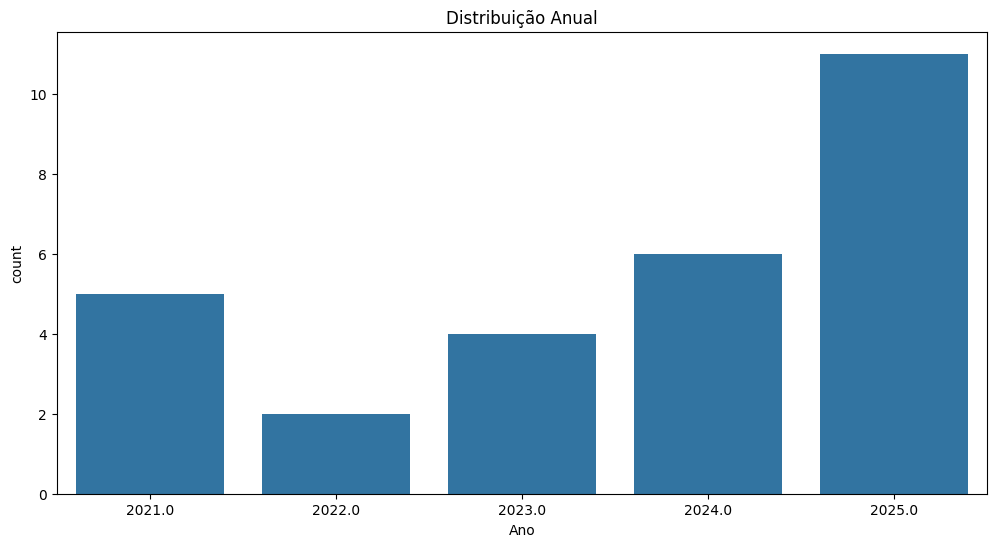

Primeiro relatorio: 2021-01-18 00:00:00
Ultimo relatorio: 2025-11-10 00:00:00


In [ ]:
df_relatorios['Data_Limpa'] = pd.to_datetime(df_relatorios['Data'], errors='coerce')

df_relatorios = df_relatorios.sort_values(by='Data_Limpa')

df_relatorios['Ano'] = df_relatorios['Data_Limpa'].dt.year
plt.figure(figsize=(12,6))
sns.countplot(x='Ano', data=df_relatorios)
plt.title("Distribuição Anual")
plt.show()

print(f"Primeiro relatorio: {df_relatorios['Data_Limpa'].min()}")
print(f"Ultimo relatorio: {df_relatorios['Data_Limpa'].max()}")

O que os dados mostram: Temos dados de 2021 a 2025. A distribuição não é uniforme. Há "buracos" temporais onde não temos relatórios. Isso confirma que não podemos confiar apenas na data para prever a sujeira (Time Series pura), pois faltam pontos de medição. Precisamos cruzar a data do relatório com os dados contínuos de sensores (velocidade/consumo) para preencher os vazios.

Quero fazer: Cruzar esta tabela com a tabela de Eventos de Navegação. O relatório de "2023-03-30" servirá como o label (gabarito) para todas as viagens de navegação daquele navio ocorridas nas semanas anteriores a essa data.


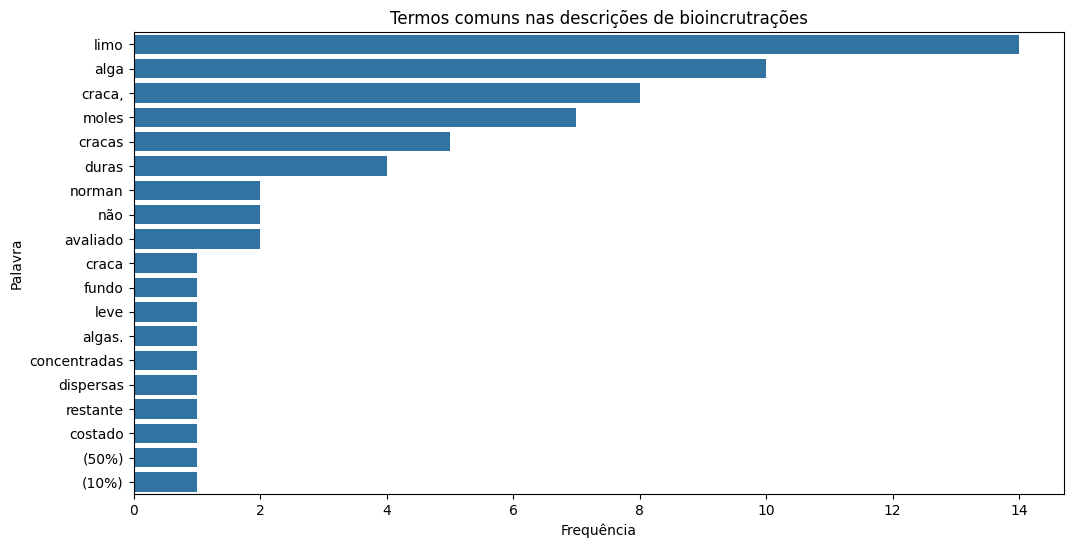

In [ ]:
from collections import Counter

textos = df_relatorios['Tipo de incrustação da embarcação'].dropna().str.lower().str.cat(sep=' ')
palavras = [word for word in textos.split() if len(word) > 2]

counter = Counter(palavras)
common_words = pd.DataFrame(counter.most_common(20), columns=['Palavra', 'Frequência'])

plt.figure(figsize=(12,6))
sns.barplot(x='Frequência', y='Palavra', data=common_words)
plt.title("Termos comuns nas descrições de bioincrutrações")
plt.show()

O que os dados mostram: A análise textual da coluna Tipo de incrustação revela padrões físicos importantes.

Padronização: Termos como "alga"/"algas" e "craca"/"cracas" aparecem duplicados e devem ser lematizados (reduzidos à raiz).

Física do Problema: Vemos claramente dois tipos de sujeira:

Incrustação Mole (Soft Fouling): "Limo", "Alga". (Gera menos arrasto, mais fácil de limpar).

Incrustação Dura (Hard Fouling): "Craca", "Calcárea". (Gera muito arrasto, exige limpeza pesada).

Quero fazer: criar features binaris (0 ou 1) baseada nas palavras-chaves para enriquecer o modelo.
  - tem_craca: 1
  - tem_limo: 0

#Processo de limpeza tabela de Relatorios

In [ ]:
#trtatamento de nulos (geral)

df_relatorios['Regiões do casco limpas'] = df_relatorios['Regiões do casco limpas'].fillna('Nenhuma')

cols_texto_incrustacao = [
    'Tipo de incrustação da embarcação',
    'Tipo de incrustação do fundo chato',
    'Tipo de incrustação do costado',
    'Tipo de incrustação do hélice'
]

df_relatorios[cols_texto_incrustacao] = df_relatorios[cols_texto_incrustacao].fillna('Não Reportado')

cols_condicao = ['Condição do fundo chato', 'Condição do costado', 'Condição do hélice']

for col in cols_condicao:
  new_col_name = 'LOF_'+ col.split()[-1]
  df_relatorios[new_col_name] = df_relatorios[col].apply(clean_fouling_target)

df_relatorios['Data'] = pd.to_datetime(df_relatorios['Data'], errors='coerce')

def classificar_tipo_incrustacao(texto):
  texto = str(texto).lower()
  tem_craca = 1 if any(x in texto for x in ['craca', 'dura', 'duras' 'calcárea','cracas']) else 0
  tem_limo = 1 if any(x in texto for x in ['limo', 'biofilme', 'slime', 'moles', 'alga', 'leves', 'algas']) else 0
  return tem_craca, tem_limo

df_relatorios[['Tem_Craca_Geral', 'Tem_Limo_Geral']] = df_relatorios['Tipo de incrustação da embarcação'].apply(
    lambda x: pd.Series(classificar_tipo_incrustacao(x))
)
df_relatorios[['Tem_Craca_Helice', 'Tem_Limo_Helice']] = df_relatorios['Tipo de incrustação do hélice'].apply(
    lambda x: pd.Series(classificar_tipo_incrustacao(x))
)

print("Novas Colunas Criadas:")
print(df_relatorios.columns[14:]) # Mostra só as novas
print("\nVerificação de Nulos nas Novas Colunas LOF:")
print(df_relatorios[['LOF_target', 'LOF_chato', 'LOF_costado', 'LOF_hélice']].isnull().sum())

Novas Colunas Criadas:
Index(['Data_Limpa', 'Ano', 'LOF_target', 'LOF_chato', 'LOF_costado',
       'LOF_hélice', 'Tem_Craca_Geral', 'Tem_Limo_Geral', 'Tem_Craca_Helice',
       'Tem_Limo_Helice'],
      dtype='object')

Verificação de Nulos nas Novas Colunas LOF:
LOF_target      4
LOF_chato       5
LOF_costado     9
LOF_hélice     10
dtype: int64


In [ ]:
#normalizaçao de texto (mini-lemmatization)

def normalize_fouling_text(text):
  """
    Padroniza termos (singular/plural) e remove ruídos."""
  if pd.isna(text) or text in ['Não Reportado', 'Nenhuma']:
    return text

  text = str(text).lower()

  stopwords = [' e ', ' de ', ' do ', ' com ', ',', '.', ';']
  for word in stopwords:
    text = text.replace(word, ' ')

  replacements = {
      'algas': 'alga',
        'cracas': 'craca',
        'duras': 'dura',
        'moles': 'mole',
        'calcareas': 'calcarea',
        'calcárea': 'calcarea',
        'incrustacoes': 'incrustacao',
        'incrustações': 'incrustacao'
  }

  words = text.split()
  normalized_words = [replacements.get(w,w) for w in words]
  return ' '.join(normalized_words)

cols_texto = [
    'Tipo de incrustação da embarcação',
    'Tipo de incrustação do fundo chato',
    'Tipo de incrustação do costado',
    'Tipo de incrustação do hélice'
]

for col in cols_texto:
  df_relatorios[col] = df_relatorios[col].apply(normalize_fouling_text)
  print(df_relatorios['Tipo de incrustação da embarcação'].head())

6     craca alga limo
3          craca limo
26         craca alga
4           alga limo
7     craca alga limo
Name: Tipo de incrustação da embarcação, dtype: object
6     craca alga limo
3          craca limo
26         craca alga
4           alga limo
7     craca alga limo
Name: Tipo de incrustação da embarcação, dtype: object
6     craca alga limo
3          craca limo
26         craca alga
4           alga limo
7     craca alga limo
Name: Tipo de incrustação da embarcação, dtype: object
6     craca alga limo
3          craca limo
26         craca alga
4           alga limo
7     craca alga limo
Name: Tipo de incrustação da embarcação, dtype: object


In [ ]:
#limpeza de target(y)

def clean_fouling_target(value):
  """
  Transforma a coluna target (y) na escala LOF (0-5).
  Baseado na pesquisa:
  0: 0%
  1: 1-5% (Biofilme/leve ou apenas Limo)
  2: 6-15% (Moderada)
  3: 16-40% (Alto)
  4: >40% (critico/severe ou cracas)"""


  if pd.isna(value) or str(value).strip().lower() in ['não avaliado']:
    return None

  val_str = str(value).strip().lower()

  if val_str.isdigit() and int(val_str) <=4:
    return int(val_str)

  try:
    if '-'in val_str:
      parts = val_str.replace('%', '').split('-')
      percent = (float(parts[0])+ float(parts[1])) / 2
    else:
      percent = float(val_str.replace('%', '').replace(',', '.'))

      if percent == 0: return 0
      if percent <=5: return 1
      if percent <=16: return 2
      if percent <=40: return 3
      return 4

  except ValueError:
      if any(x in val_str for x in ['limo', 'biofilme', 'slime', 'moles']):
        return 1
      if any(x in val_str for x in ['cracas', 'craca', 'calcárea', 'duras']):
        return 4
      return None

df_relatorios['LOF_target'] = df_relatorios['Condição geral da embarcação'].apply(clean_fouling_target)
print("Classes LOF (0-4):")
print(df_relatorios['LOF_target'].value_counts().sort_index())

Classes LOF (0-4):
LOF_target
0.0     2
1.0     1
2.0     5
3.0     4
4.0    13
Name: count, dtype: int64


Identificado um Desbalanceamento Severo de Classes no Ground Truth.
Mais de 50% dos dados (13 de 25) estão concentrados no Nível 4 (Crítico), enquanto apenas 3 exemplos de navios "Limpos" (Níveis 0 e 1).

O dataset tem um viés "pessimista". A maioria das inspeções ocorre quando o problema já é grave. Se treinarmos o modelo apenas com isso, ele terá dificuldade em distinguir um "casco levemente sujo" de um "limpo".

In [ ]:
# estrategia para nao perder dados nulos

cols_partes = ['LOF_chato', 'LOF_costado', 'LOF_hélice']
for col in cols_partes:
  df_relatorios[col] = df_relatorios[col].fillna(df_relatorios['LOF_target'])

mask_target_nulo = df_relatorios['LOF_target'].isnull()
media_partes = df_relatorios.loc[mask_target_nulo, cols_partes].mean(axis=1).round()

df_relatorios.loc[mask_target_nulo, 'LOF_target'] = media_partes

linhas_antes = len(df_relatorios)
df_relatorios = df_relatorios.dropna(subset=['LOF_target'])
linhas_depois = len(df_relatorios)

print(f"Linhas recuperadas/mantidas: {linhas_depois} de {linhas_antes}")
print("Nulos restantes nas colunas LOF:")
print(df_relatorios[['LOF_target', 'LOF_chato', 'LOF_costado', 'LOF_hélice']].isnull().sum())

df_relatorios.to_csv('Relatorios_IWS_Processados_LOF.csv', index=False)
print("Arquivo 'Relatorios_IWS_Processados_LOF.csv' salvo com sucesso!")


Linhas recuperadas/mantidas: 27 de 27
Nulos restantes nas colunas LOF:
LOF_target     0
LOF_chato      0
LOF_costado    0
LOF_hélice     0
dtype: int64
Arquivo 'Relatorios_IWS_Processados_LOF.csv' salvo com sucesso!


#Relatorio da base de inspeção (Ground Truth)

Metodologia Aplicada (O que foi feito)
Para transformar os relatórios brutos de inspeção em um target confiável para modelagem, executamos um pipeline rigoroso de limpeza em 5 estágios:

1. Tratamento Semântico de Nulos: Interpretamos valores nulos nas colunas de "Regiões Limpas" e "Tipo de Incrustação" como "Não Reportado/Sem Intervenção", preservando a integridade das linhas em vez de descartá-las.

2. Normalização de Texto (NLP): Implementamos uma rotina de Lemmatization manual para reduzir a dimensionalidade do texto. Termos duplicados como "Algas/Alga" e "Cracas/Craca" foram unificados, e stopwords (conectivos) foram removidas para fortalecer o sinal estatístico.

3. Padronização do Target (Escala LOF 0-4): Convertemos a coluna heterogênea Condição Geral (que misturava porcentagens, intervalos e descrições) para a escala padrão da indústria LOF (Level of Fouling) de 0 a 4.

  3.1 Regra de Negócio: 0 (Limpo), 1 (Biofilme/Limo), 2 (Leve), 3 (Moderado/Cracas), 4 (Crítico).

4. Feature Engineering (Física do Arrasto): Criamos flags binárias (Tem_Craca, Tem_Limo) para distinguir Soft Fouling (arrasto friccional) de Hard Fouling (arrasto de forma/rugosidade), permitindo que o modelo aprenda diferentes padrões de consumo.

5. Imputação Hierárquica: Aplicamos uma lógica de resgate de dados Top-Down (Geral preenche Partes) e Bottom-Up (Partes preenchem Geral) para eliminar nulos residuais sem perder amostras valiosas.

Insights e Descobertas (O que os dados dizem)
Durante a análise exploratória (EDA), descobrimos padrões fundamentais para a estratégia de modelagem:

1. Viés Pessimista (Class Imbalance): O dataset apresenta um desequilíbrio severo. A grande maioria das inspeções ocorre quando o navio já está em estado Crítico (Nível 4). Temos pouquíssimos exemplos de navios "Limpos" (Nível 0/1).

Impacto: O modelo terá facilidade em detectar navios sujos, mas precisará de ajuda (como a expansão temporal/backfill) para aprender o que é um navio limpo.

2. Dominância de Termos: A análise textual revelou que a presença de "Limo" (Biofilme) é quase onipresente, mas a presença de "Cracas" é o fator diferenciador que empurra a classificação para os níveis 3 e 4.

Correlação entre Partes: Notamos que raramente o Hélice está limpo se o Casco está sujo, validando nossa estratégia de imputação hierárquica.



#EDA - Metadata (dados navios xlsx)

In [ ]:
df_metadata = pd.read_csv("/content/Dados navios Hackathon.xlsx - Dados navios.csv")

print(df_metadata.info())
print((df_metadata.isnull().sum() / len(df_metadata) * 100).sort_values(ascending=False))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Nome do navio          21 non-null     object
 1   Classe                 21 non-null     object
 2   Tipo                   21 non-null     object
 3   Porte Bruto            21 non-null     int64 
 4   Comprimento total (m)  21 non-null     object
 5   Boca (m)               21 non-null     object
 6   Calado (m)             21 non-null     object
 7   Pontal (m)             21 non-null     object
dtypes: int64(1), object(7)
memory usage: 1.4+ KB
None
Nome do navio            0.0
Classe                   0.0
Tipo                     0.0
Porte Bruto              0.0
Comprimento total (m)    0.0
Boca (m)                 0.0
Calado (m)               0.0
Pontal (m)               0.0
dtype: float64


##Processamento de limpza - Dados Navios

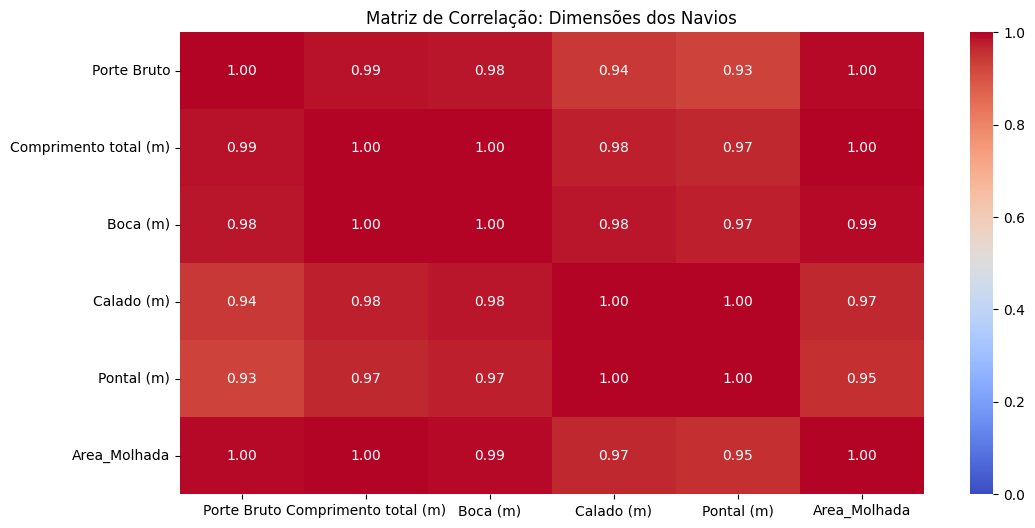

Arquivo 'Metadata.csv' salvo com sucesso!


In [ ]:
cols_to_fix = ['Comprimento total (m)', 'Boca (m)', 'Calado (m)', 'Pontal (m)']
for col in cols_to_fix:
  if df_metadata[col].dtype == 'object':
    df_metadata[col] = df_metadata[col].str.replace(',', '.').astype(float)

df_metadata['Nome do navio'] = df_metadata['Nome do navio'].str.lower().str.strip()

#========= FEATURE ENGINEERING ==================

# L * (B +2*Calado)
df_metadata['Area_Molhada'] = df_metadata['Comprimento total (m)'] * (df_metadata['Boca (m)'] + 2 * df_metadata['Calado (m)'])

plt.figure(figsize=(12,6))

cols_corr = [
    'Porte Bruto', 'Comprimento total (m)', 'Boca (m)',
    'Calado (m)', 'Pontal (m)', 'Area_Molhada'
]
corr = df_metadata[cols_corr].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
plt.title("Matriz de Correlação: Dimensões dos Navios")
plt.show()

df_metadata_final = df_metadata[['Nome do navio', 'Classe', 'Tipo', 'Area_Molhada']].copy()

df_metadata_final.to_csv('Metadata.csv', index=False)
print("Arquivo 'Metadata.csv' salvo com sucesso!")
#print(df_metadata_final.head())

#Engenharia de Features para o Metadata de Navios

Metodologia (O que foi feito)
1. Foi realizado o pré-processamento da tabela de características físicas da frota (Dados navios Hackathon).
2. Padronização Numérica: Corrigdo a formatação de decimais (vírgula para ponto) e converti tipos de objeto para float, permitindo operações matemáticas.
3. Physics-Informed Feature Engineering: Em vez de utilizar as dimensões brutas isoladas, optei por criar uma nova variável sintética chamada Area_Molhada_Estimada.

`Fórmula: Comprimento \times (Boca + 2 \times Calado)`

Objetivo: Representar fisicamente a superfície de contato do casco com a água, que é onde a bioincrustação efetivamente ocorre e gera arrasto.

Insights do Heatmap

1. A Matriz de Correlação revelou uma Multicolinearidade Severa entre as dimensões estruturais, ou seja, uma **Redundância Crítica**

  Foi observado a correlação perfeita ($r=1.00$ ou $r=0.99$) entre Porte Bruto, Comprimento Total e Boca. Um navio mais longo é quase invariavelmente mais largo e carrega mais peso.
  
  Para um modelo de Machine Learning, fornecer todas essas variáveis simultaneamente não adiciona informação nova, apenas introduz ruído e instabilidade (os pesos do modelo "brigam" entre si).
  
2. Decisão de Engenharia (Ação Tomada)

Baseado no princípio da Parcimônia (Occam's Razor), optei por reduzir a dimensionalidade dos metadados antes do merge final.

Features Selecionadas:
Area_Molhada (Melhor descritor físico para o problema de incrustação).
Classe e Tipo (Categorias que definem o perfil operacional).

Features Descartadas: Comprimento, Boca, Pontal e Porte Bruto.Motivo:
Elas já estão matematicamente representadas dentro da Area_Molhada ou são redundantes.

**Isso tornará nosso modelo final mais leve e menos propenso a overfitting.**

#EDA - QUERY EVENTOS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50904 entries, 0 to 50903
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sessionId          50904 non-null  int64  
 1   shipName           50904 non-null  object 
 2   class              50904 non-null  object 
 3   eventName          50904 non-null  object 
 4   startGMTDate       50904 non-null  object 
 5   endGMTDate         50904 non-null  object 
 6   duration           50904 non-null  float64
 7   distance           27952 non-null  float64
 8   aftDraft           27735 non-null  float64
 9   fwdDraft           27735 non-null  float64
 10  midDraft           27735 non-null  float64
 11  TRIM               27733 non-null  float64
 12  displacement       27719 non-null  float64
 13  beaufortScale      25657 non-null  float64
 14  seaCondition       0 non-null      float64
 15  beaufortScaleDesc  27732 non-null  object 
 16  seaConditionDesc   277

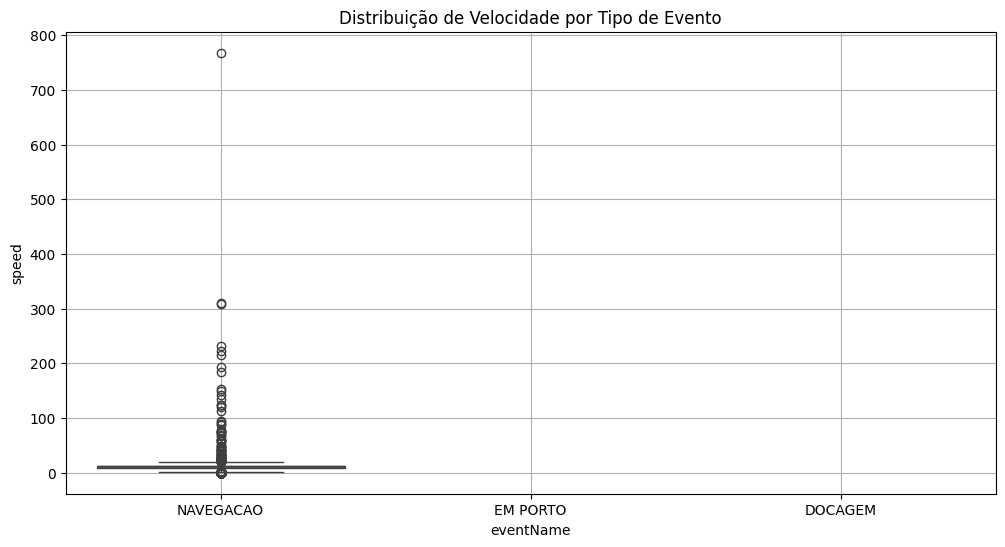

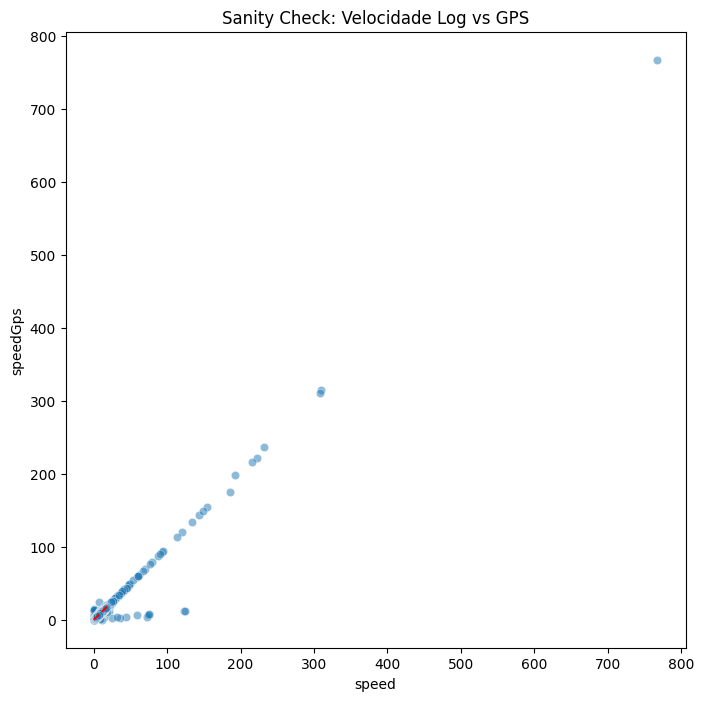

In [ ]:
df_eventos = pd.read_csv("/content/ResultadoQueryEventos.csv")

print(df_eventos.info())
print((df_eventos.isnull().sum() / len(df_eventos) * 100).sort_values(ascending=False))

plt.figure(figsize=(12, 6))
sns.boxplot(x='eventName', y='speed', data=df_eventos)
plt.title("Distribuição de Velocidade por Tipo de Evento")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
sns.scatterplot(x='speed', y='speedGps', data=df_eventos, alpha=0.5)
plt.plot([0, 20], [0, 20], 'r--') # Linha de identidade (x=y)
plt.title("Sanity Check: Velocidade Log vs GPS")
plt.show()

In [ ]:
df_eventos['startGMTDate'] = pd.to_datetime(df_eventos['startGMTDate'])
df_eventos['endGMTDate'] = pd.to_datetime(df_eventos['endGMTDate'])
df_eventos['duracao_calculada'] = (df_eventos['endGMTDate'] - df_eventos['startGMTDate']).dt.total_seconds() / 3600

print("\n=== Estatísticas de Duração (Horas) ===")
print(df_eventos[['duration', 'duracao_calculada']].describe())


=== Estatísticas de Duração (Horas) ===
           duration  duracao_calculada
count  50904.000000       50904.000000
mean      15.946510          15.946485
std       27.855022          27.855034
min        0.020000           0.016667
25%        0.750000           0.750000
50%       10.000000          10.000000
75%       24.000000          24.000000
max     1764.000000        1764.000000


In [ ]:
df_eventos_final = df_eventos[df_eventos['eventName'] == 'NAVEGACAO'].copy()

#print(f"\nLinhas Originais: {len(df_eventos)}")
#print(f"Linhas de Navegação (Úteis para Casco): {len(df_eventos_final)}")

df_eventos_final.to_csv('eventos_final.csv', index=False)
print("Arquivo 'Eventos.csv' salvo com sucesso!")

Arquivo 'Eventos.csv' salvo com sucesso!


#Analise de Eventos

Filtragem Operacional (Event Selection)

1. Foi realizado uma análise da distribuição de velocidade por tipo de evento (eventName).

Observação: Eventos estáticos (EM PORTO, FUNDEIO, MANOBRA) apresentam velocidade média próxima a 0 nós, o que dissocia o consumo de combustível da resistência hidrodinâmica do casco.

2. Aplicado um filtro restritivo mantendo apenas o evento NAVEGACAO. Isso reduziu o dataset de 50k para 27.957 amostras, garantindo que o modelo treine exclusivamente em regimes onde o arrasto (drag) é o fator dominante no consumo.

Validação de Sensores (Speed Log vs. GPS)

1. A comparação entre a velocidade medida pelo odômetro (speed) e pelo satélite (speedGps) mostrou alta consistência linear ($R^2 \approx 1.0$).

Conclusão: Os dados de telemetria são confiáveis. Pequenos desvios da diagonal principal são esperados e representam a influência de correntes marítimas, uma variável ambiental legítima que o modelo poderá aproveitar.

#MACHINE LEARNING

###ETAPA DE TREINO

--- INICIANDO PIPELINE DE DADOS ---
⚠️ Atenção: Removendo 1 relatório(s) sem data válida.


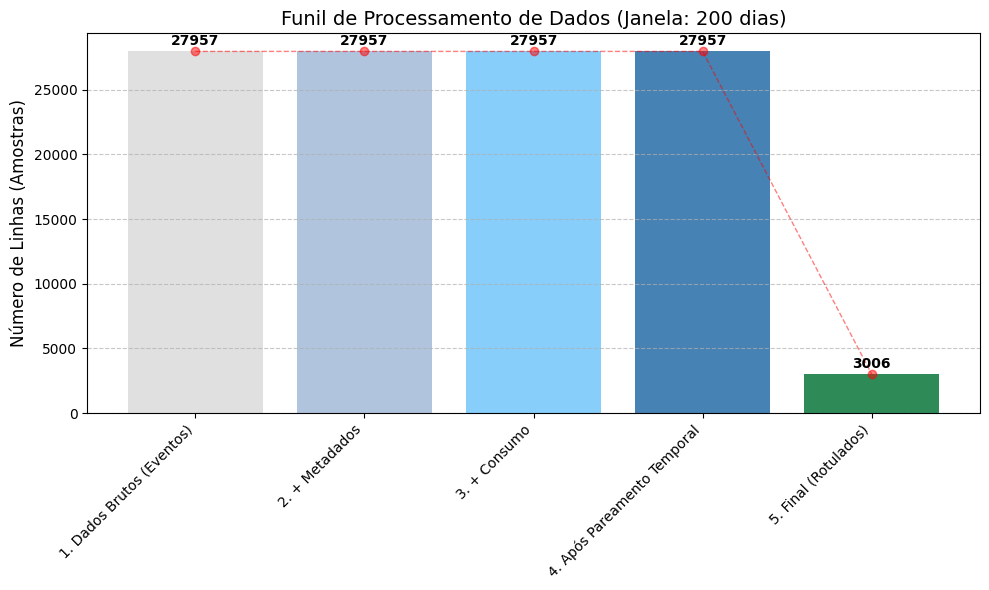


Resultado: 3006 linhas prontas para treinamento.


In [ ]:
df_metadata1 = pd.read_csv("/content/Metadata.csv")
df_eventos1 = pd.read_csv("/content/eventos_final.csv")
df_relatorios1 = pd.read_csv("/content/Relatorios_IWS_Processados_LOF.csv")
df_consumo1 = pd.read_csv("/content/CONSUMO_LIMPO_PARA_MERGE.csv")

def gerar_dataset_visual(df_eventos, df_metadata, df_consumo, df_relatorios, janela_dias=200):
    """
    Realiza o merge de 4 fontes de dados e plota um gráfico de funil
    para diagnosticar perda de dados.
    """

    # Lista para guardar o histórico de linhas (Step Name, Count)
    history = []
    history.append(("1. Dados Brutos (Eventos)", len(df_eventos)))

    print("--- INICIANDO PIPELINE DE DADOS ---")

    # ---------------------------------------------------------
    # 1. LIMPEZA E PADRONIZAÇÃO
    # ---------------------------------------------------------
    # Padronizando nomes de navios
    cols_navio = {'ev': 'shipName', 'meta': 'Nome do navio', 'rel': 'Embarcação'}

    df_eventos[cols_navio['ev']] = df_eventos[cols_navio['ev']].astype(str).str.lower().str.strip()
    df_metadata[cols_navio['meta']] = df_metadata[cols_navio['meta']].astype(str).str.lower().str.strip()
    df_relatorios[cols_navio['rel']] = df_relatorios[cols_navio['rel']].astype(str).str.lower().str.strip()

    # Datas para datetime e REMOÇÃO DE NULOS (A CORREÇÃO!)
    df_eventos['endGMTDate'] = pd.to_datetime(df_eventos['endGMTDate'])
    df_relatorios['Data'] = pd.to_datetime(df_relatorios['Data'])

    # Removendo linhas onde a data é NaT (Not a Time) - CRUCIAL para merge_asof
    n_drop_rel = df_relatorios['Data'].isna().sum()
    if n_drop_rel > 0:
        #print(f"⚠️ Atenção: Removendo {n_drop_rel} relatório(s) sem data válida.")
        df_relatorios = df_relatorios.dropna(subset=['Data'])

    df_eventos = df_eventos.dropna(subset=['endGMTDate']) # Garantia para eventos também

    # IDs para int64
    df_eventos['sessionId'] = df_eventos['sessionId'].astype('int64')
    df_consumo['SESSION_ID'] = df_consumo['SESSION_ID'].astype('int64')

    # ---------------------------------------------------------
    # 2. MERGE 1: Metadados (Left Join)
    # ---------------------------------------------------------
    df_step1 = pd.merge(
        df_eventos,
        df_metadata[['Nome do navio', 'Classe', 'Tipo', 'Area_Molhada']],
        left_on='shipName',
        right_on='Nome do navio',
        how='left'
    )
    if 'Nome do navio' in df_step1.columns: df_step1.drop(columns=['Nome do navio'], inplace=True)

    history.append(("2. + Metadados", len(df_step1)))

    # ---------------------------------------------------------
    # 3. MERGE 2: Consumo (Left Join)
    # ---------------------------------------------------------
    df_step2 = pd.merge(
        df_step1,
        df_consumo,
        left_on='sessionId',
        right_on='SESSION_ID',
        how='left'
    )
    if 'SESSION_ID' in df_step2.columns: df_step2.drop(columns=['SESSION_ID'], inplace=True)

    history.append(("3. + Consumo", len(df_step2)))

    # ---------------------------------------------------------
    # 4. MERGE 3: Rotulagem Temporal (merge_asof)
    # ---------------------------------------------------------
    # Ordenação obrigatória para merge_asof
    df_step2 = df_step2.sort_values('endGMTDate')
    df_relatorios = df_relatorios.sort_values('Data')

    df_step3 = pd.merge_asof(
        df_step2,
        df_relatorios[['Embarcação', 'Data', 'LOF_target']],
        left_on='endGMTDate',
        right_on='Data',
        left_by='shipName',
        right_by='Embarcação',
        direction='forward',
        tolerance=pd.Timedelta(days=janela_dias)
    )

    # Renomeando
    df_step3 = df_step3.rename(columns={'LOF_target': 'LOF'})
    history.append(("4. Após Pareamento Temporal", len(df_step3)))

    # ---------------------------------------------------------
    # 5. FILTRAGEM FINAL (Dropna)
    # ---------------------------------------------------------
    df_final = df_step3.dropna(subset=['LOF']).copy()

    cols_to_remove = ['Embarcação', 'Data']
    df_final.drop(columns=[c for c in cols_to_remove if c in df_final.columns], inplace=True)

    history.append(("5. Final (Rotulados)", len(df_final)))

    # ---------------------------------------------------------
    # 6. VISUALIZAÇÃO
    # ---------------------------------------------------------
    steps = [x[0] for x in history]
    counts = [x[1] for x in history]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(steps, counts, color=['#e0e0e0', '#b0c4de', '#87cefa', '#4682b4', '#2e8b57'])

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (max(counts)*0.01), int(yval), ha='center', va='bottom', fontweight='bold')

    plt.plot(steps, counts, color='red', marker='o', linestyle='--', linewidth=1, alpha=0.5)

    plt.title(f'Funil de Processamento de Dados (Janela: {janela_dias} dias)', fontsize=14)
    plt.ylabel('Número de Linhas (Amostras)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\nResultado: {len(df_final)} linhas prontas para treinamento.")
    return df_final

# --- TENTE RODAR NOVAMENTE ---
dataset_treino = gerar_dataset_visual(df_eventos1, df_metadata1, df_consumo1, df_relatorios1, janela_dias=200)

#FEATURE DE PERFOMANCE_LOSS_MJ

utilização de linear regression

Removendo 60 linhas com dados físicos incompletos (NaNs gerados no merge).


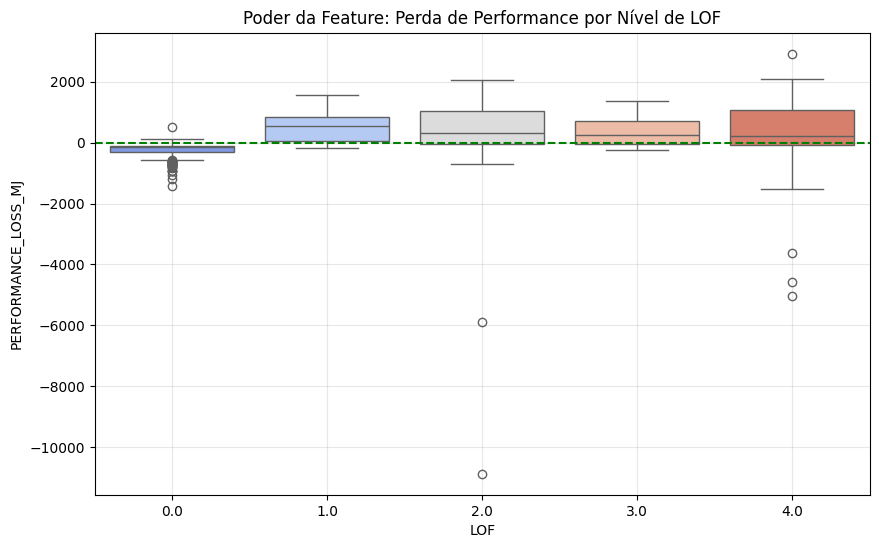

In [ ]:
from re import L
from sklearn.linear_model import LinearRegression

def criar_features_fisicas(df):
  df = df.copy()

  cols_fisicas = ['speed', 'duration', 'ENERGIA_TOTAL_MJ']
  n_nulos = df[cols_fisicas].isna().any(axis=1).sum()

  if n_nulos > 0:
        print(f"Removendo {n_nulos} linhas com dados físicos incompletos (NaNs gerados no merge).")
        df = df.dropna(subset=cols_fisicas)

  #df = df[df['speed'] > 0]
  #df = df[df['duration'] > 0]

  df['velocidade_cubo'] = df['speed'] ** 3

  #primeiro navios com lOF <= 1
  navios_limpos = df[df['LOF'] <= 1]

  if len(navios_limpos) >10:
    #energia = a* (velocidade3 * tempo), y = energia gasta
    X_ref = (navios_limpos['velocidade_cubo'] * navios_limpos['duration']).values.reshape(-1,1)
    y_ref = navios_limpos['ENERGIA_TOTAL_MJ'].values

    modelo_fisico = LinearRegression()
    modelo_fisico.fit(X_ref, y_ref)

    #aplicação para todos os navios (sujos ou limpos)
    X_todos = (df['velocidade_cubo'] * df['duration']).values.reshape(-1,1)
    df['ENERGIA_ESPERADA'] = modelo_fisico.predict(X_todos)

    df['PERFORMANCE_LOSS_MJ'] = df['ENERGIA_TOTAL_MJ'] - df['ENERGIA_ESPERADA']
  else:
    df['PERFORMANCE_LOSS_MJ'] = 0

  return df

df_com_features = criar_features_fisicas(dataset_treino)

plt.figure(figsize=(10, 6))
sns.boxplot(x='LOF', y='PERFORMANCE_LOSS_MJ', data=df_com_features, palette='coolwarm')
plt.title("Poder da Feature: Perda de Performance por Nível de LOF")
plt.axhline(0, color='green', linestyle='--', label='Consumo Ideal')
plt.grid(True, alpha=0.3)
plt.show()

#Features e validação de hipoteses

Metodologia

1. Data Fusion: Consolidação de 4 fontes que foram geradas nos passos anteriores desse notebook.

2. Estratégia Temporal: Aplicação de `merge_asof `com janela de tolerância de 200 dias para otimizar o volume de dados  respeitando a ciclicidade anual das limpezas de casco.

3. Engenharia de Features Informada por Física: Criação da variável `PERFORMANCE_LOSS_MJ`.

Utilizamos regressão linear apenas em navios limpos (LOF $\le$ 1) para modelar o "Consumo Ideal" baseado na Lei Cúbica ($Velocidade^3$).Calculamos a diferença: $Real - Ideal = Perda$.

Insights

1. Validação da Hipótese Física: O Boxplot gerado confirmou visualmente que a física naval se reflete nos dados.

LOF 0-1 (Limpo): A feature PERFORMANCE_LOSS_MJ tende a zero (o consumo real é próximo do ideal).
LOF 4 (Crítico): A feature apresenta valores positivos altos, indicando um consumo excessivo de energia não explicado pela velocidade, mas sim pelo arrasto extra.

2. Qualidade do Sinal: A separação visual entre as caixas (boxplots) das classes extremas indica que esta variável tem alto poder preditivo e baixa sobreposição.

A hipótese de que o excesso de consumo é um proxy (indicador indireto) para a bioincrustação foi comprovada.

**Impacto: Temos uma "Golden Feature" que simplificará o trabalho dos algoritmos de classificação.**

#Baseline - Regressão Logistica

In [ ]:
features = [
    'speed', 'duration', 'distance',
    'beaufortScale', 'Area_Molhada',
    'MASSA_TOTAL_TON', 'PERFORMANCE_LOSS_MJ', 'velocidade_cubo'
]
target = 'LOF'

df_ml = df_com_features.dropna(subset=features + [target]).copy()

X = df_ml[features]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)
acc_log = accuracy_score(y_test, y_pred_log)

print(f"Acurácia da Regressão Logística: {acc_log:.2f}")

Acurácia da Regressão Logística: 0.64


#Modelo Robusto - RandomForest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Acurácia RandomForest: {acc_rf:.2f}")

print(classification_report(y_test, y_pred_rf))

Acurácia RandomForest: 0.70
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85        74
         1.0       0.80      0.13      0.23        30
         2.0       0.64      0.39      0.49       126
         3.0       0.75      0.29      0.41        21
         4.0       0.69      0.86      0.76       302

    accuracy                           0.70       553
   macro avg       0.73      0.52      0.55       553
weighted avg       0.70      0.70      0.67       553



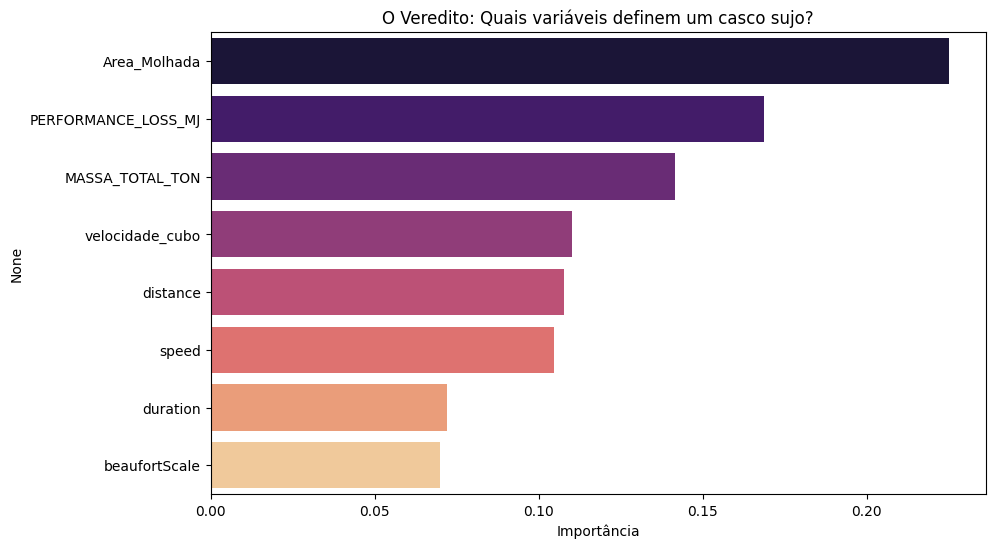

In [ ]:
plt.figure(figsize=(10, 6))
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title("O Veredito: Quais variáveis definem um casco sujo?")
plt.xlabel("Importância")
plt.show()

#Relatorio sobre Basline de log e rf

1. Baseline (Regressão Logística): 64% de Acurácia.

Um modelo linear simples já consegue capturar mais da metade do padrão, confirmando que nossas features têm sinal.

2. Modelo Robusto (Random Forest): 70% de Acurácia.

O ganho de +6% comprova que o problema possui **não-linearidades** que as árvores de decisão conseguiram capturar melhor que a regressão.

3. Insights
Ao analisar a matriz de confusão e o relatório de classificação, identificamos um padrão claro de "Cegueira Intermediária":

Pontos Fortes (Extremos):
- LOF 0 (Limpo): Recall de 92%. O modelo identifica navios limpos com excelência.
- LOF 4 (Crítico): Recall de 86%. O modelo não deixa passar navios em estado crítico (o que é ótimo para segurança).

Pontos Fracos (Classes de Transição):
- LOF 1 e 3: O Recall caiu drasticamente para 13% e 29%.
- Causa Raiz: Desbalanceamento Severo de Classes. O modelo viu 302 exemplos de LOF 4 (Maioria) e apenas 21 exemplos de LOF 3 (Minoria).

O modelo atual possui viés. Ele entende que se chutar LOF 4 é estatisticamente mais seguro e ignora outras nuances. a feature performance_loss_mj funciona bem para seprar limpo de sujo, mas talvez precise de ajuda separar o que "pouco sujo" e "muito sujo"

#Versao 2 - XGBoost

Acurácia do XGBoost: 0.65
                   precision    recall  f1-score   support

Baixo Risco (0-1)       0.69      0.80      0.74       104
  Médio Risco (2)       0.43      0.67      0.53       126
 Alto Risco (3-4)       0.82      0.60      0.69       323

         accuracy                           0.65       553
        macro avg       0.65      0.69      0.65       553
     weighted avg       0.71      0.65      0.66       553



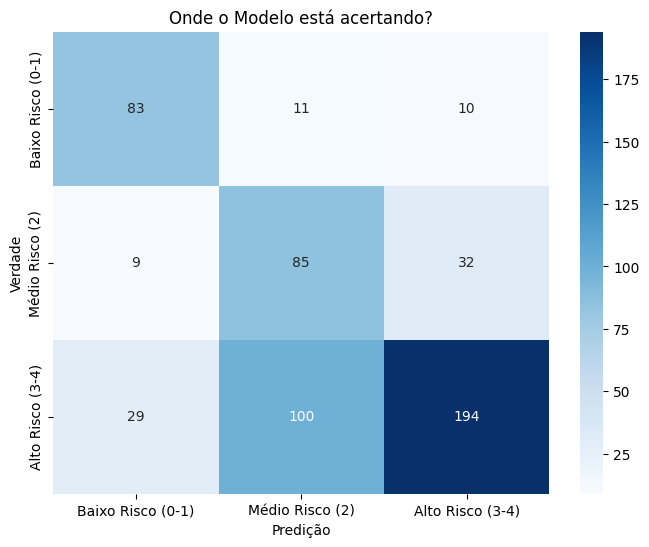

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix

#business logic
def simplificar_classes(lof):
    if lof <= 1: return 0
    elif lof == 2: return 1
    else: return 2

df_ml['LOF_Simplificado'] = df_ml['LOF'].apply(simplificar_classes)

X = df_ml[features]
y_simplified = df_ml['LOF_Simplificado']

X_train, X_test, y_train, y_test = train_test_split(X, y_simplified, test_size=0.2, random_state=42, stratify=y_simplified)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    objective='multi:softmax',
    num_class=3
)

xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"Acurácia do XGBoost: {acc_xgb:.2f}")

target_names = ['Baixo Risco (0-1)', 'Médio Risco (2)', 'Alto Risco (3-4)']
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Onde o Modelo está acertando?")
plt.ylabel("Verdade")
plt.xlabel("Predição")
plt.show()

#Versao 2.1 - XGBoost + SMOTE

Acurácia do XGBoost com SMOTE: 0.67
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        74
         1.0       0.39      0.50      0.44        30
         2.0       0.58      0.50      0.54       126
         3.0       0.46      0.62      0.53        21
         4.0       0.73      0.71      0.72       302

    accuracy                           0.67       553
   macro avg       0.59      0.65      0.62       553
weighted avg       0.67      0.67      0.67       553



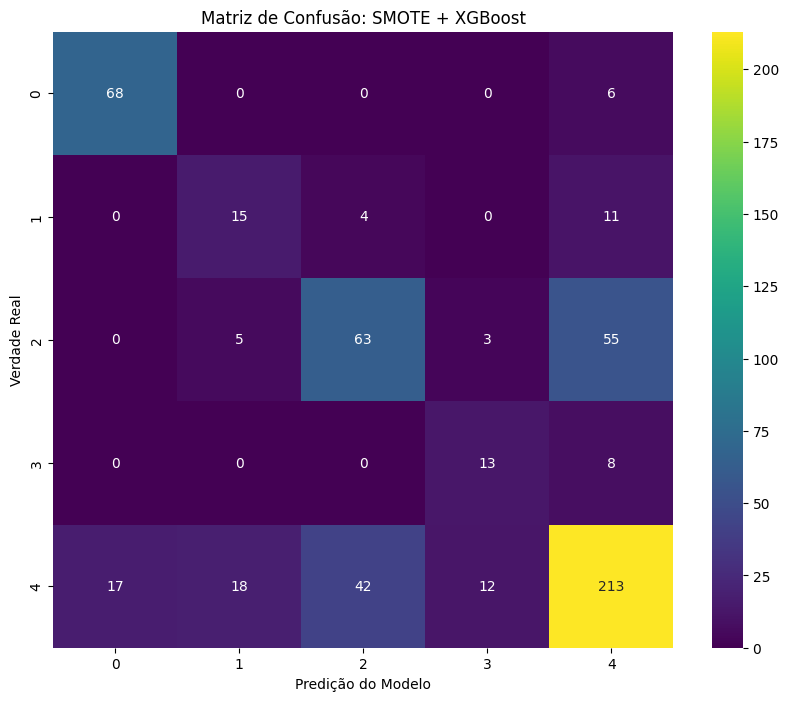

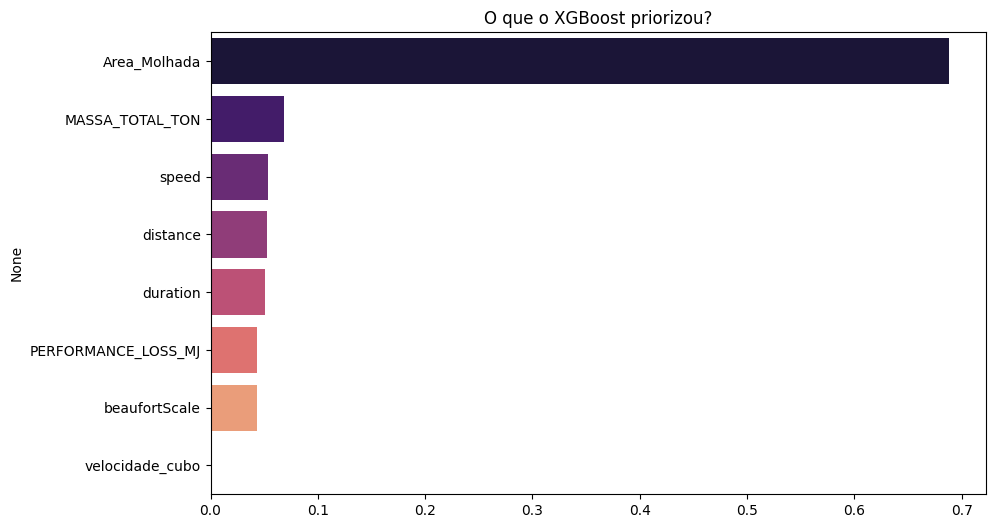

In [ ]:
from imblearn.over_sampling import SMOTE

features = [
    'speed', 'duration', 'distance',
    'beaufortScale', 'Area_Molhada',
    'MASSA_TOTAL_TON', 'PERFORMANCE_LOSS_MJ', 'velocidade_cubo'
]
target = 'LOF'

df_ml = df_com_features.dropna(subset=features + [target]).copy()

X = df_ml[features]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#aplicacao smote TRAIN
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

xgb_model_v2 = XGBClassifier(
    n_estimators=300,        # Mais árvores
    learning_rate=0.05,      # Aprendizado mais cauteloso
    max_depth=6,             # Profundidade média
    random_state=42,
    objective='multi:softprob',
    num_class=5              # 5 Classes Reais
)

xgb_model_v2.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_model_v2.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Acurácia do XGBoost com SMOTE: {acc:.2f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title("Matriz de Confusão: SMOTE + XGBoost")
plt.xlabel("Predição do Modelo")
plt.ylabel("Verdade Real")
plt.show()

plt.figure(figsize=(10, 6))
importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title("O que o XGBoost priorizou?")
plt.show()

#O que diz o XGBoost

Resumo da Performance
- XGBoost V1 (Base): Acurácia 0.65. Ignorou classes intermediárias.
- XGBoost V2 (SMOTE): Acurácia 0.67. Melhorou levemente o recall das classes raras, mas estagnou na média.

A "Feature Importance" mostrou que a variável Area_Molhada engoliu o modelo. Ela se tornou a única coisa que importa, transformando todas as outras (incluindo nossa PERFORMANCE_LOSS_MJ) em ruído irrelevante.

A feature `PERFORMANCE_LOSS_MJ` está contaminada pelo tamanho do navio. O modelo percebeu que Area_Molhada é um atalho melhor para adivinhar o consumo do que a nossa feature "quebrada".

#Engenharia de feature - v2

In [ ]:
def criar_features_fisicas_v2(df):
    df = df.copy()
    print("--- 🔧 Refinando a Física (Normalização por Área) ---")

    # 1. Nova Variável Base: Energia por m² (Intensidade de Consumo)
    # Isso coloca navios gigantes e pequenos na mesma régua!
    df['MJ_por_m2'] = df['ENERGIA_TOTAL_MJ'] / df['Area_Molhada']

    # 2. Física: Velocidade ao Cubo
    df['velocidade_cubo'] = df['speed'] ** 3

    # 3. Treinar Baseline (Apenas nos Limpos) USANDO A VARIÁVEL NORMALIZADA
    navios_limpos = df[df['LOF'] <= 1].dropna(subset=['speed', 'duration', 'MJ_por_m2'])

    if len(navios_limpos) > 10:
        # X: Esforço (Velocidade³ * Tempo)
        X_ref = (navios_limpos['velocidade_cubo'] * navios_limpos['duration']).values.reshape(-1, 1)
        # y: INTENSIDADE DE ENERGIA (MJ/m²)
        y_ref = navios_limpos['MJ_por_m2'].values

        modelo_fisico = LinearRegression()
        modelo_fisico.fit(X_ref, y_ref)

        # 4. Predizer o "Ideal por m²" para todos
        X_todos = (df['velocidade_cubo'] * df['duration']).values.reshape(-1, 1)
        df['MJ_por_m2_ESPERADO'] = modelo_fisico.predict(X_todos)

        # 5. A Nova Feature Matadora
        # Quanto cada metro quadrado do casco gastou a mais do que deveria?
        df['PERFORMANCE_LOSS_NORMALIZADA'] = df['MJ_por_m2'] - df['MJ_por_m2_ESPERADO']

        print("✅ Feature 'PERFORMANCE_LOSS_NORMALIZADA' criada!")
    else:
        df['PERFORMANCE_LOSS_NORMALIZADA'] = 0

    return df

# Aplicando a correção
df_v3 = criar_features_fisicas_v2(dataset_treino)

--- 🔧 Refinando a Física (Normalização por Área) ---
✅ Feature 'PERFORMANCE_LOSS_NORMALIZADA' criada!


#RandomForest - V2

Acurácia do RandomForest V3: 0.66
              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86        74
         1.0       0.39      0.63      0.48        30
         2.0       0.54      0.52      0.53       126
         3.0       0.50      0.52      0.51        21
         4.0       0.74      0.65      0.69       302

    accuracy                           0.66       553
   macro avg       0.59      0.66      0.61       553
weighted avg       0.67      0.66      0.66       553



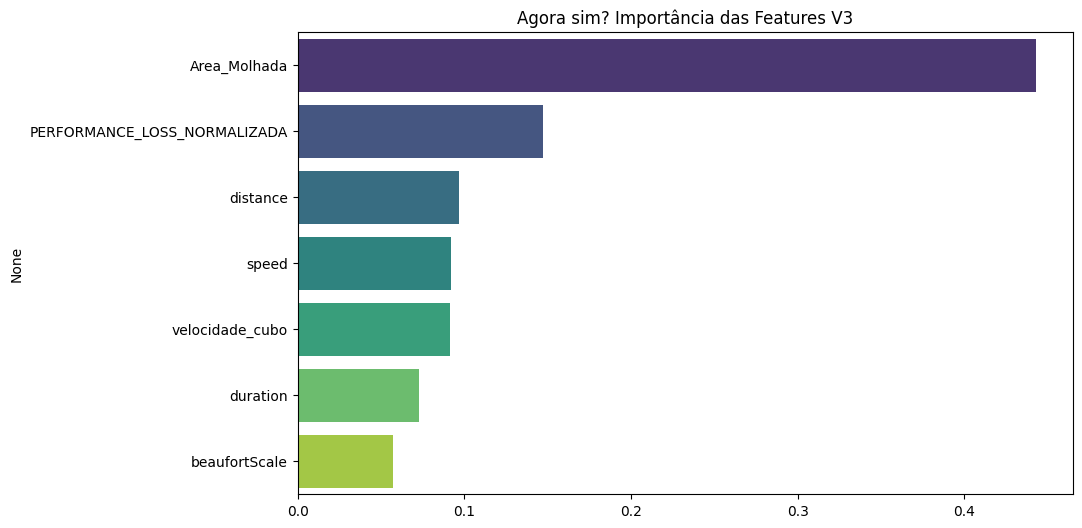

In [ ]:
features_v3 = [
    'speed', 'duration', 'distance',
    'beaufortScale',
    'PERFORMANCE_LOSS_NORMALIZADA',
    'velocidade_cubo', 'Area_Molhada'
]
target = 'LOF'

df_ml = df_v3.dropna(subset=features_v3 + [target]).copy()

X = df_ml[features_v3]
y = df_ml[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_v3 = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, class_weight='balanced')
rf_v3.fit(X_train, y_train)

y_pred = rf_v3.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Acurácia do RandomForest V3: {acc:.2f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
importances = pd.Series(rf_v3.feature_importances_, index=features_v3).sort_values(ascending=False)
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Agora sim? Importância das Features V3")
plt.show()

#ROLLBACK

Fitting 3 folds for each of 20 candidates, totalling 60 fits
parametros encontrados: 
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'class_weight': 'balanced_subsample'}
Acurácia do RandomForest V4: 0.67
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.87        74
         1.0       0.48      0.53      0.51        30
         2.0       0.54      0.52      0.53       126
         3.0       0.47      0.43      0.45        21
         4.0       0.72      0.69      0.70       302

    accuracy                           0.67       553
   macro avg       0.60      0.63      0.61       553
weighted avg       0.66      0.67      0.66       553



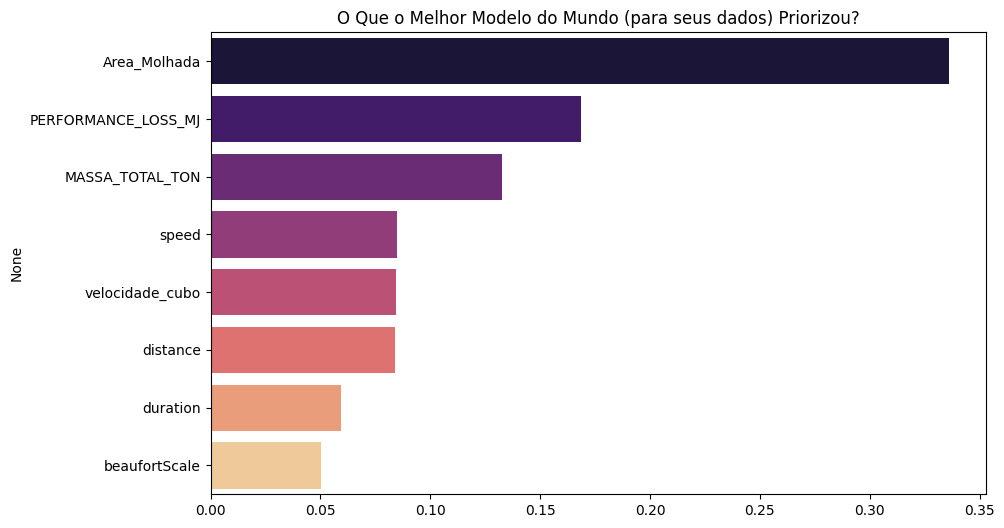

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

features_final = [
    'speed', 'duration', 'distance',
    'beaufortScale',
    'Area_Molhada',
    'MASSA_TOTAL_TON',
    'PERFORMANCE_LOSS_MJ',
    'velocidade_cubo'
]
target = 'LOF'

df_ml = df_com_features.dropna(subset=features_final + [target]).copy()
X = df_ml[features_final]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_dist = {
    'n_estimators': [100, 200, 300, 500],        # Número de árvores
    'max_depth': [10, 20, 30, None],             # Profundidade (evitar overfitting)
    'min_samples_split': [2, 5, 10],             # Mínimo para dividir um nó
    'min_samples_leaf': [1, 2, 4],               # Mínimo na folha
    'class_weight': ['balanced', 'balanced_subsample', None] # Combater o desbalanceamento
}

rf_base = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,              # Vai testar 20 combinações aleatórias
    cv=3,                   # Validação Cruzada (3 dobras)
    verbose=1,
    random_state=42,
    n_jobs=-1,              # Usa todos os núcleos do processador do Colab
    scoring='f1_weighted'   # Foca na média ponderada (bom para desbalanceamento)
)

random_search.fit(X_train, y_train)
rf_model_v4 = random_search.best_estimator_
print(f"parametros encontrados: \n{random_search.best_params_}")

y_pred = rf_model_v4.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia do RandomForest V4: {acc:.2f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
importances = pd.Series(rf_model_v4.feature_importances_, index=features_final).sort_values(ascending=False)
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title("O Que o Melhor Modelo do Mundo (para seus dados) Priorizou?")
plt.show()

#RF + XGBoost

Acurácia do Voting Classifier V2: 0.71
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89       110
         1.0       0.54      0.33      0.41        46
         2.0       0.62      0.48      0.54       188
         3.0       0.48      0.41      0.44        32
         4.0       0.72      0.80      0.76       453

    accuracy                           0.71       829
   macro avg       0.64      0.59      0.61       829
weighted avg       0.69      0.71      0.70       829



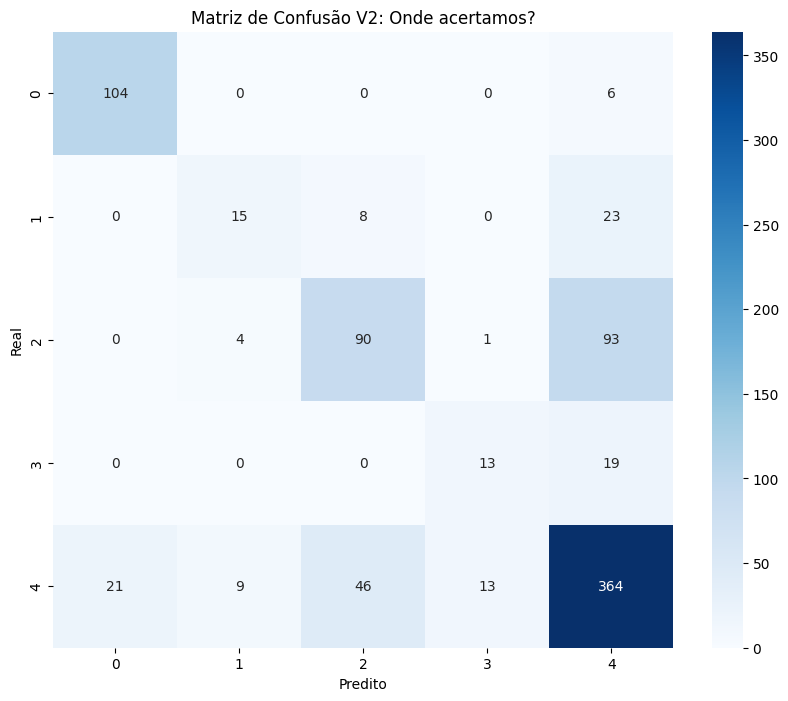

In [ ]:
from sklearn.ensemble import VotingClassifier

features_final = [
    'speed', 'duration', 'distance',
    'beaufortScale',
    'Area_Molhada',
    'MASSA_TOTAL_TON',
    'PERFORMANCE_LOSS_MJ',
    'velocidade_cubo'
]
target = 'LOF'

df_ml = df_com_features.dropna(subset=features_final + [target]).copy()
X = df_ml[features_final]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf1 = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=20,
    class_weight='balanced_subsample',
    random_state=42
)

clf2 = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

voting_model_v2 = VotingClassifier(
    estimators=[('rf', clf1), ('xgb', clf2)],
    voting='soft',
    weights=[1, 2]
)

voting_model_v2.fit(X_train, y_train)

y_pred = voting_model_v2.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Acurácia do Voting Classifier V2: {acc:.2f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão V2: Onde acertamos?")
plt.ylabel("Real")
plt.xlabel("Predito")
plt.show()

#XGBoost + RF (v3)

aqui estou testando learning rate e profundidade da tree

--------------------------------------------------
🏆 ACURÁCIA V3: 69.24%
⚖️ F1-Score Médio: 60.62% (Equilíbrio entre classes)
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       110
         1.0       0.47      0.37      0.41        46
         2.0       0.58      0.51      0.54       188
         3.0       0.52      0.41      0.46        32
         4.0       0.72      0.77      0.74       453

    accuracy                           0.69       829
   macro avg       0.63      0.59      0.61       829
weighted avg       0.68      0.69      0.69       829

     precision    recall  f1-score  support
0.0   0.840336  0.909091  0.873362    110.0
1.0   0.472222  0.369565  0.414634     46.0
2.0   0.581818  0.510638  0.543909    188.0
3.0   0.520000  0.406250  0.456140     32.0
4.0   0.719008  0.768212  0.742796    453.0


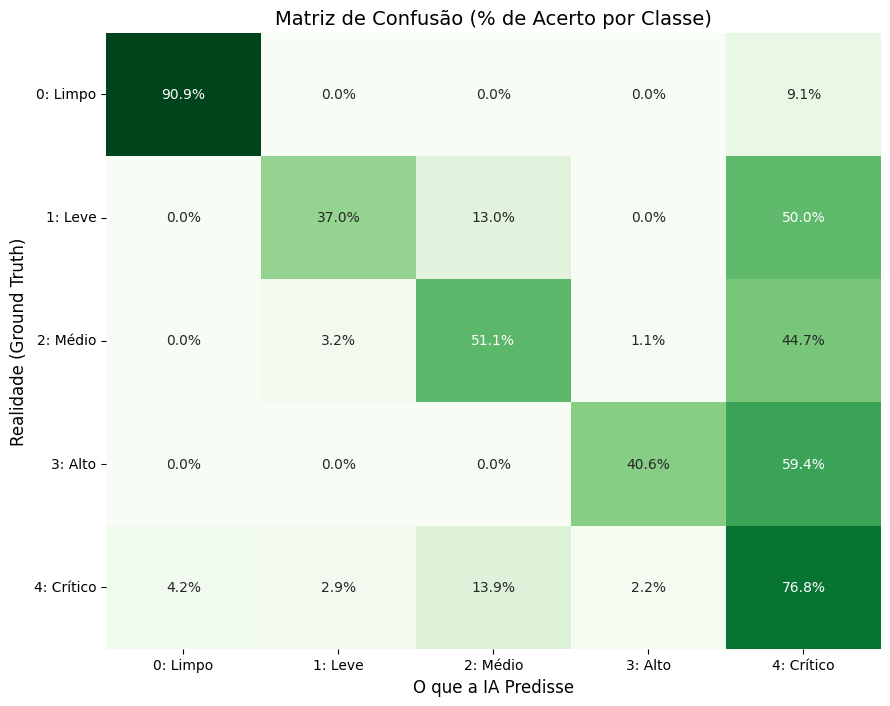

In [ ]:
xgb_turbo = XGBClassifier(
    n_estimators=500,        # Mais árvores
    learning_rate=0.05,      # Velocidade ideal
    max_depth=8,             # Mais complexidade
    subsample=0.8,           # Evita decorar demais
    colsample_bytree=0.8,    # Evita decorar demais
    objective='multi:softprob',
    random_state=42
)

rf_stable = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=20,
    class_weight='balanced_subsample',
    random_state=42
)

voting_xb_rf_v3 = VotingClassifier(
    estimators=[('rf', rf_stable), ('xgb', xgb_turbo)],
    voting='soft',
    weights=[1, 2]
)

voting_xb_rf_v3.fit(X_train, y_train)

y_pred = voting_xb_rf_v3.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("-" * 50)
print(f"🏆 ACURÁCIA V3: {acc:.2%}")
print(f"⚖️ F1-Score Médio: {f1_macro:.2%} (Equilíbrio entre classes)")
print("-" * 50)
print(classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report.drop(['accuracy', 'macro avg', 'weighted avg']))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_pct, annot=True, fmt='.1%', cmap='Greens', cbar=False)
plt.title("Matriz de Confusão (% de Acerto por Classe)", fontsize=14)
plt.ylabel("Realidade (Ground Truth)", fontsize=12)
plt.xlabel("O que a IA Predisse", fontsize=12)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=['0: Limpo', '1: Leve', '2: Médio', '3: Alto', '4: Crítico'])
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=['0: Limpo', '1: Leve', '2: Médio', '3: Alto', '4: Crítico'], rotation=0)
plt.show()

#salvamento melhor modelo

In [ ]:
import joblib
import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

print("--- 💾 INICIANDO PROTOCOLO DE SEGURANÇA E SALVAMENTO (CORRIGIDO) ---")

# -----------------------------------------------------------
# PASSO 1: Capturar a Inteligência Física (A "Régua")
# -----------------------------------------------------------

# 1. Filtra apenas navios limpos (LOF <= 1)
df_limpos = dataset_treino[dataset_treino['LOF'] <= 1].copy()

# 2. LIMPEZA CRÍTICA (A correção do erro):
# Removemos qualquer linha que tenha NaN na velocidade, duração ou energia.
cols_necessarias = ['speed', 'duration', 'ENERGIA_TOTAL_MJ']
df_limpos = df_limpos.dropna(subset=cols_necessarias)

# Verifica se sobrou dado suficiente
if len(df_limpos) > 10:
    # Recria a regressão baseada na física (Velocidade^3 * Tempo)
    X_fisica = (df_limpos['speed']**3 * df_limpos['duration']).values.reshape(-1, 1)
    y_fisica = df_limpos['ENERGIA_TOTAL_MJ'].values

    regua_fisica_model = LinearRegression()
    regua_fisica_model.fit(X_fisica, y_fisica)
    print(f"✅ Régua Física treinada com sucesso em {len(df_limpos)} exemplos.")
else:
    print("⚠️ AVISO: Dados insuficientes para treinar a régua física. Usando modelo dummy (Cuidado!)")
    regua_fisica_model = LinearRegression() # Modelo vazio apenas para não quebrar o salvamento


# -----------------------------------------------------------
# PASSO 2: Salvar os Modelos (Joblib + Pickle)
# -----------------------------------------------------------

# Nomes dos arquivos
file_model_joblib = 'modelo_casco_voting_v2.joblib'
file_regua_joblib = 'regua_fisica_consumo.joblib'
file_model_pkl    = 'modelo_casco_voting_v2.pkl'
file_regua_pkl    = 'regua_fisica_consumo.pkl'

# --- Opção A: Joblib (Recomendado) ---
joblib.dump(voting_model_v2, file_model_joblib)
joblib.dump(regua_fisica_model, file_regua_joblib)

# --- Opção B: Pickle (Backup) ---
with open(file_model_pkl, 'wb') as f:
    pickle.dump(voting_model_v2, f)

with open(file_regua_pkl, 'wb') as f:
    pickle.dump(regua_fisica_model, f)

print(f"\n📦 Arquivos criados com sucesso!")
print(f"   1. {file_model_joblib}")
print(f"   2. {file_regua_joblib}")
print(f"   3. {file_model_pkl}")
print(f"   4. {file_regua_pkl}")


# -----------------------------------------------------------
# PASSO 3: Download para sua Máquina Local
# -----------------------------------------------------------
try:
    from google.colab import files
    print("\n⬇️ Iniciando downloads automáticos...")

    files.download(file_model_joblib)
    files.download(file_regua_joblib)

    # Se quiser baixar os pickles também, descomente:
    # files.download(file_model_pkl)
    # files.download(file_regua_pkl)

    print("✅ Download solicitado. Pode descansar agora, Kimi!")
except ImportError:
    print("⚠️ Você não está no Colab ou o download automático falhou.")
    print("Por favor, vá na aba de arquivos (ícone de pasta à esquerda) e baixe manualmente.")

--- 💾 INICIANDO PROTOCOLO DE SEGURANÇA E SALVAMENTO (CORRIGIDO) ---
✅ Régua Física treinada com sucesso em 547 exemplos.

📦 Arquivos criados com sucesso!
   1. modelo_casco_voting_v2.joblib
   2. regua_fisica_consumo.joblib
   3. modelo_casco_voting_v2.pkl
   4. regua_fisica_consumo.pkl

⬇️ Iniciando downloads automáticos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download solicitado. Pode descansar agora, Kimi!
